# Imports and Setup

In [1]:
import argparse
import glob
import os
import random
import re
import pandas as pd
import numpy as np
import csv
import json
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import collections
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
import pickle

from string2string.alignment import NeedlemanWunsch
from string2string.misc.plotting_functions import plot_pairwise_alignment


%load_ext autoreload
%autoreload 2

In [3]:
# Spacy setup. Need to be done once.
!pip -q install -U spacy
!pip install -U spacy-lookups-data
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm
!pip install plotly
!pip install string2string
## !pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.1 MB/s eta 0:00:00m eta 0:00:010:0101
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 48.4 MB/s eta 0:00:00m eta 0:00:01:01:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [2]:
import spacy
from spacy.lang.es.examples import sentences 
from spacy import displacy

print(spacy.__version__)
print(pd.__version__)

# from nltk.parse import stanford, corenlp
NLP_ES = spacy.load("es_core_news_sm")
NLP_EN = spacy.load("en_core_web_sm")

3.7.2
1.4.2


In [3]:
# Helper methods
def add_neighbors_of(idx, cur_order, words, id_to_head, head_to_ids):
    if idx is None:
        # Handle edge case where we do not have an index to work with.
        return
    if cur_order > 3:
        # We are only interesting in the first three orders of dependency:
        #  1 - self
        #  2 - immediate neighbors and 
        #  3 - 1-skip neighbors
        return
    if f'{idx}' in words:
        # Node has been processed already
        return
    if idx not in id_to_head:
        # The current index does not identify a word in the corrected sentence.
        # This can happen as the correction index holds indices into string with both 
        # versions (corrected and uncorrected) appended.
        return

    # Add current index and its order to the dict
    words[f'{idx}'] = cur_order
    
    # Process head of current index
    upstream = id_to_head[idx]
    add_neighbors_of(upstream, cur_order + 1, words, id_to_head, head_to_ids)

    # Process words that are immediately downstream of current index
    if idx in head_to_ids:
        downstream = head_to_ids[idx]
        [add_neighbors_of(down_idx, cur_order + 1, words, id_to_head, head_to_ids) for down_idx in downstream]
    

def dep_parsing_tree(nlp, text, correction_index, verbosity=0):
    if len(correction_index) == 0:
        return dict()
    
    doc = nlp(text)
    js_str = doc.to_json()
    id_to_head = dict()
    head_to_ids = dict()
    for token in js_str["tokens"]:
        id = token["id"]
        head = token["head"]
        if token['pos'] != 'PUNCT':
            id_to_head[id] = head
            if head in head_to_ids:
                head_to_ids[head].append(id)
            else:
                head_to_ids[head] = [id]
    if verbosity > 0:
        print(f'id -> head: {id_to_head}')
        print(f'head -> ids: {head_to_ids}')            
        
    pred_parse_order = dict()
    for cor_idx in correction_index:
        add_neighbors_of(cor_idx, 1, pred_parse_order, id_to_head, head_to_ids)

    pred_parse_order = dict(sorted(pred_parse_order.items()))
    if verbosity > 0:
        df_dep_tree = pd.DataFrame()
        df_dep_tree['text'] = [token.text for token in doc]
        df_dep_tree['lemma'] = [token.lemma_ for token in doc]
        df_dep_tree['is_punctuation'] = [token.is_punct for token in doc]
        df_dep_tree['is_space'] = [token.is_space for token in doc]
        df_dep_tree['shape'] = [token.shape_ for token in doc]
        df_dep_tree['part_of_speech'] = [token.pos_ for token in doc]
        df_dep_tree['pos_tag'] = [token.tag_ for token in doc]
        df_dep_tree['head'] = [token.head.text for token in doc] 
        df_dep_tree['dep'] = [token.dep_ for token in doc]
        html = displacy.render(doc, style="dep")
        HTML(html)
    return pred_parse_order

def to_json_df(in_df):
    df_proj = in_df[in_df.predicted_parsing_order.notnull()][['target', 'source', 'evidence_index', 'correction_index', 'error_type', 'predicted_parsing_order', 'origin']]    
    df_proj = df_proj.dropna()
    print(f'Selected {df_proj.shape[0]} non-null rows from {in_df.shape[0]} rows. {in_df.shape[0] - df_proj.shape[0]} rows dropped.')
    df_json = df_proj.copy(deep=True)
    df_json['json'] = df_proj.apply(lambda x: x.to_json(), axis=1)
    return df_json[['json']]

def export_as_json(df, train_file, test_file, dev_file):
    def write_out(df, filename):
        with open(f'{args.PROCESSED_DATA_FOLDER}/{filename}', "w+") as file1:
            for i, row in df.iterrows():
                file1.write(f'{json.dumps(eval(row.json))}\n')

    json_df = to_json_df(df)

    train_df, test_dev_df = train_test_split(json_df, test_size=0.2)
    test_df, dev_df = train_test_split(test_dev_df, test_size=0.5)
    # tt.to_csv(args.PROCESSED_DATA_FOLDER + "/rows_as_json.csv", index=False, header=False, quoting=csv.QUOTE_NONE, escapechar=" ")
    write_out(train_df, train_file)
    write_out(test_df, test_file)
    write_out(dev_df, dev_file)
    
# Helper methods to convert to NER format
def idx2vec(idx, length):
    if isinstance(idx, list):
        if len(idx) != 0:
            idx_vec = [1 if i in idx else 0 for i in range(length)]
        else:
            idx_vec = [0] * length
    elif isinstance(idx, dict):
        idx_vec = [0] * length
        for k, v in idx.items():
            if int(k) < len(idx_vec):
                idx_vec[int(k)] = v
    return idx_vec

def to_ner(csv_filename, pkl_filename):
    sep_token = ['[MOD]']
    data = []
    
    with open(f'{args.PROCESSED_DATA_FOLDER}/{csv_filename}', 'r') as f:
        for line in f:
            data.append(json.loads(line))    
    
    # convert into ner data structure
    def sent_to_ner_data(sentence, evidence_index, correction_index, error_type, parsing_order, ids=0, prefix=True):
        sent_data = []
        for j, token in enumerate(sentence):
            new_tokens = token
            if evidence_index:  # for dev and train data
                if evidence_index[j]:
                    type = args.CLASS_IDS[error_type]
                    if prefix:
                        if j == 0 or evidence_index[j - 1] == 0:
                            cls = 'B-' + type
                        else:
                            cls = 'I-' + type
                    else:
                        cls = type
                else:
                    cls = 'O'
                sent_data.append([
                    ids,
                    new_tokens,
                    cls,
                    args.CLASS_IDS[error_type],
                    correction_index[j],
                    parsing_order[j]
                ])
        return sent_data

    new_data = []
    for i, d in tqdm(enumerate(data)):
        sentence = d['target'] + sep_token + d['source']
        correction_index = idx2vec(d['correction_index'], len(sentence))
        evidence_index = idx2vec(d['evidence_index'], len(sentence))
        predicted_parsing_order = idx2vec(d['predicted_parsing_order'], len(sentence))
        ner_d = sent_to_ner_data(sentence, evidence_index, correction_index, d['error_type'], predicted_parsing_order, ids=i)
        new_data.extend(ner_d)

    with open(f'{args.PROCESSED_DATA_FOLDER}/{pkl_filename}', 'wb') as f:
        pickle.dump(new_data, f)
    pd.DataFrame(new_data).to_csv(f'{args.PROCESSED_DATA_FOLDER}/tt.csv', index=False)
    

In [4]:
from utils import Config
args = Config()
args.CLASS_IDS

{'article': 'a',
 'gender agreement': 'ga',
 'gender and number agreement': 'gna',
 'number agreement': 'na',
 'evidence word': 'ew'}

In [5]:
print(args.id2label)
print(args.label2id)

{0: 'B-ga', 1: 'B-na', 2: 'B-ew', 3: 'O'}
{'B-ga': 0, 'B-na': 1, 'B-ew': 2, 'O': 3}


# Load Data and do Sanity Tests

## Sanity on Full Data

In [6]:
def load():
    # Converters not working
    filename = "final.csv"
    filename = "dataset_with_evident_word.csv"
    df = pd.read_csv(f'{args.PROCESSED_DATA_FOLDER}/{filename}', index_col=None, header=0)
    if filename == "dataset_with_evident_word.csv":
        df["error_type"] = df.new_error_type
        df['evidence_index'] = df.apply(lambda row: eval(row.final_evident_index), axis=1)
    else:
        df['evidence_index'] = np.empty((len(df), 0)).tolist()

    
    # The source, target and correction_index cols are loaded as string version of lists. Convert them to actual lists.
    df.source = df.apply(lambda row: eval(row.source), axis=1)
    df.target = df.apply(lambda row: eval(row.target), axis=1)
    df.correction_index = df.apply(lambda row: eval(row.correction_index), axis=1)
    
    df['predicted_parsing_order'] = ""
    df['origin'] = 'A'
    return df

df_raw = load()

In [7]:
# Check the columns
df_raw.columns

Index(['Unnamed: 0', 'paragraph_id', 'sentence_id', 'course', 'essay_new',
       'annotated_sentence', 'full_error_tag', 'error_tag', 'correction',
       'error', 'target', 'source', 'correction_index', 'new_error_type',
       'final_evident_index', 'target_sentence', 'source_sentence',
       'error_type', 'evidence_index', 'predicted_parsing_order', 'origin'],
      dtype='object')

In [8]:
# All rows should have an error_type
df_raw[df_raw.error_type.isnull()]

,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,full_error_tag,error_tag,correction,error,...,source,correction_index,new_error_type,final_evident_index,target_sentence,source_sentence,error_type,evidence_index,predicted_parsing_order,origin


In [9]:
# Check for null values
df_raw[df_raw.notnull()].count()

Unnamed: 0                 5212
paragraph_id               5212
sentence_id                5212
course                     5212
essay_new                  5212
annotated_sentence         5212
full_error_tag             5212
error_tag                  5212
correction                 5165
error                      4798
target                     5212
source                     5212
correction_index           5212
new_error_type             5212
final_evident_index        5212
target_sentence            5212
source_sentence            5212
error_type                 5212
evidence_index             5212
predicted_parsing_order    5212
origin                     5212
dtype: int64

In [10]:
df_raw.isna().sum()

Unnamed: 0                   0
paragraph_id                 0
sentence_id                  0
course                       0
essay_new                    0
annotated_sentence           0
full_error_tag               0
error_tag                    0
correction                  47
error                      414
target                       0
source                       0
correction_index             0
new_error_type               0
final_evident_index          0
target_sentence              0
source_sentence              0
error_type                   0
evidence_index               0
predicted_parsing_order      0
origin                       0
dtype: int64

In [11]:
# with pd.option_context('display.max_colwidth', None):
#     print(df_raw[['source', 'target']].sample(n=50))


## Split Dataset into With Errors and Without Errors

In [12]:
# Split dataset into two dataframes one with errors and one without
def split_on_error(df):
    df_no_errors = df.query('error_type == "None"').copy()
    df_no_errors.reset_index(inplace=True)
    df_no_errors.rename(columns={'index': "orig_index"}, inplace=True)
    df_errors = df.query('error_type != "None"').copy()
    df_errors['orig_error_type'] = df_errors['error_type']
    df_errors['error_type'] = df_errors['new_error_type']

    df_errors.reset_index(inplace=True)
    df_errors.rename(columns={'index': "orig_index"}, inplace=True)
    return df_errors, df_no_errors

df_errors, df_no_errors = split_on_error(df_raw)

In [13]:
df_errors.index[(df_errors.essay_new == 'Entonces será certificado como “perfecto".')]

Int64Index([5166, 5167], dtype='int64')

In [14]:
df_errors[df_errors.notnull()].count()

orig_index                 5212
Unnamed: 0                 5212
paragraph_id               5212
sentence_id                5212
course                     5212
essay_new                  5212
annotated_sentence         5212
full_error_tag             5212
error_tag                  5212
correction                 5165
error                      4798
target                     5212
source                     5212
correction_index           5212
new_error_type             5212
final_evident_index        5212
target_sentence            5212
source_sentence            5212
error_type                 5212
evidence_index             5212
predicted_parsing_order    5212
origin                     5212
orig_error_type            5212
dtype: int64

In [15]:
df_no_errors[df_no_errors.notnull()].count()

orig_index                 0
Unnamed: 0                 0
paragraph_id               0
sentence_id                0
course                     0
essay_new                  0
annotated_sentence         0
full_error_tag             0
error_tag                  0
correction                 0
error                      0
target                     0
source                     0
correction_index           0
new_error_type             0
final_evident_index        0
target_sentence            0
source_sentence            0
error_type                 0
evidence_index             0
predicted_parsing_order    0
origin                     0
dtype: int64

In [16]:
df_errors.full_error_tag.unique()

array(['[]{a}<az:do:an>', '[a]{}<za:do:inan>', '[el]{la}<ga:fm:det:an>',
       ..., '[palido]{pálida}<ga:fm:adj:an>',
       '[muchos]{muchos}<na:sp:det:inan>',
       '[muchas]{muchas}<na:sp:det:inan>'], dtype=object)

In [17]:
df_errors.error_type.unique()

array(['article', 'gender agreement', 'number agreement',
       'gender and number agreement'], dtype=object)

In [18]:
# # Reduce the number of error classes to 4 - ga, na, ga-na and az.
# error_map = {
# 'aa:do': 'az',
# 'az:do': 'az',
# 'za:do': 'az',
# 'aa:io': 'az',
# 'az:io': 'az',
# 'na:ps': 'na',
# 'ga:fm': 'ga',
# 'ga:mf:det:aty': 'ga',
# 'ga:mf': 'ga',
# 'ig:f': 'na',
# 'na:sp': 'na',
# 'in:s': 'na',
# 'ga:na:fm:ps': 'ga-na',
# 'ga:fm:det:aty': 'ga',
# 'ga:ps': 'ga',
# 'ig:e': 'na',
# 'ig:m': 'na',
# 'ga:na:mf:ps': 'ga-na',
# 'ga:mf:noun:aty': 'ga',
# 'ga:mf:adj:aty': 'ga',
# 'ga:na:fm:sp': 'ga-na',
# 'ga:na:mf:sp': 'ga-na',
# 'in:p': 'na',
# 'ga:fm:adj:aty': 'ga',
# 'ga:fm:noun:aty': 'ga',
# 'ig:in:f:s': 'na',
# 'ga:fm:gat:noun': 'ga',
# 'in:p:gat:noun': 'na',
# 'na:sp:gat:noun': 'na',
# 'ga:mf:pron:aty': 'ga',
# 'in:s:gat:noun': 'na',
# 'ga': 'ga'}

# df_errors['error_type'] = df_errors.apply(lambda row: error_map[row.orig_error_type], axis=1)

In [19]:
df_errors.error_type.value_counts()

gender agreement               2993
number agreement               1460
article                         468
gender and number agreement     291
Name: error_type, dtype: int64

## Fix Data Issues

### Handle Non-breaking Space Character

In [20]:
# Some of the sentences have non-breaking space ('\xa0') which breaks dependency tree logic.
# Count number of lines with non-breaking space in them
def cleanup_nbsp(df):
    rows_with_nbsp = df[(df.essay_new.str.contains('\xa0'))]
    print(f"{rows_with_nbsp.shape[0]} rows have non-breaking spaces before cleanup.")
    df.essay_new = df.essay_new.str.replace('\xa0', ' ')
    rows_with_nbsp = df[(df.essay_new.str.contains('\xa0'))]
    print(f"{rows_with_nbsp.shape[0]} rows have non-breaking spaces after cleanup.")
    return df

df_errors = cleanup_nbsp(df_errors)

273 rows have non-breaking spaces before cleanup.
0 rows have non-breaking spaces after cleanup.


### Handle Newline Characters

In [21]:
# Some of the sentences have new line characters which breaks dependency tree logic.
def cleanup_new_line(df):
    rows = df[(df.essay_new.str.contains(r'\n+'))]
    print(f"{rows.shape[0]} rows have new line before cleanup.")
    sampled = None
    if rows.shape[0] > 0:
        sampled = rows.sample(10).index
        print(f'Few samples before cleanup:')
        print(df.iloc[sampled].essay_new)
    df.essay_new = df.essay_new.str.replace('\n', ' ')
    if sampled is not None:
        print(f'\nSame entries after cleanup:')
        print(df.iloc[sampled].essay_new)

    rows = df[(df.essay_new.str.contains('\n'))]
    print(f"{rows.shape[0]} rows have double spaces after cleanup.")
    return df

df_errors, df_no_errors = split_on_error(df_raw)
df_errors = cleanup_new_line(df_errors)

71 rows have new line before cleanup.
Few samples before cleanup:
182     A la fin de película, ella lastimó la protagon...
4855    Una Vacación Perfecta\n\nUn mes antes de comen...
1966    \n\nTraería mucho dinero para comprar la ropa ...
2447     \n\nPara mí, las vacaciones perfectas serían ...
1963    \n\nSi viajaría a Norway, yo visitara mi famil...
4854    Una Vacación Perfecta\n\nUn mes antes de comen...
2206           \n\nEsta es un día regular de mi vocación.
3841    A la fin de película, ella lastimó la protagon...
5162    Llevaria mi familia al Museo Nacional para mir...
5132    \n\nPor la próxima tres días, vamos a Disneyla...
Name: essay_new, dtype: object

Same entries after cleanup:
182     A la fin de película, ella lastimó la protagon...
4855    Una Vacación Perfecta  Un mes antes de comenza...
1966      Traería mucho dinero para comprar la ropa y ...
2447       Para mí, las vacaciones perfectas serían un...
1963      Si viajaría a Norway, yo visitara mi familia...
4854

### Handle Double Space Characters

In [22]:
# Some of the sentences have multiple spaces which breaks dependency tree logic.
# Count number of lines with multiple spaces in them
def cleanup_double_spaces(df):
    rows = df[(df.essay_new.str.contains(r'\s\s+'))]
    print(f"{rows.shape[0]} rows have double spaces before cleanup.")
    sampled = None
    if rows.shape[0] > 0:
        sampled = rows.sample(10).index
        print(f'Few samples before cleanup:')
        print(df.iloc[sampled].essay_new)
    # df.essay_new = df.essay_new.str.replace('  ', ' ')

    df.essay_new = df.essay_new.str.replace(r'\s+', ' ', regex=True).str.strip()
    if sampled is not None:
        print(f'\nSame entries after cleanup:')
        print(df.iloc[sampled].essay_new)

    print(f"{df[(df.essay_new.str.contains('  '))].shape[0]} rows have double spaces after cleanup.")
    return df

# df_errors, df_no_errors = split_on_error(df_raw)
df_errors = cleanup_double_spaces(df_errors)

139 rows have double spaces before cleanup.
Few samples before cleanup:
2206               Esta es un día regular de mi vocación.
4110    Por el viernes yo quiero ver los Lakers en “St...
2447       Para mí, las vacaciones perfectas serían un...
4622       "Una vacacion perfecta" Mi vacacíon perfect...
2709    Yo quiero cantar y bailar en la  playa y conoz...
3993                        Otro persona famoso es Oprah.
4860    Mi Vacación Ideal  Mi vacación ideal es en Haw...
1534      Los canciones más populares de Rhianna en el...
591     Llevaria mi familia al Museo Nacional para mir...
129           Nosotros nos quedamos en los Estados Uni...
Name: essay_new, dtype: object

Same entries after cleanup:
2206               Esta es un día regular de mi vocación.
4110    Por el viernes yo quiero ver los Lakers en “St...
2447    Para mí, las vacaciones perfectas serían una p...
4622    "Una vacacion perfecta" Mi vacacíon perfecta e...
2709    Yo quiero cantar y bailar en la playa y conozc..

In [23]:
df_errors.iloc[[1078, 1472]].essay_new

1078                          Mickey tiene orejas grande.
1472    Sus ninas estan muy buenas chicas y su esposo ...
Name: essay_new, dtype: object

### Sanity Check Lines with Errors

In [24]:
def compute_status(row):
    num_len_mismatch = 0
    num_extra_corrections = 0
    source = row.source
    target = row.target
    correction_index = set(row.correction_index)
    row_status = 'GOOD'
    if len(source) != len(target):
        num_len_mismatch = num_len_mismatch + 1
        row_status = 'LEN_MISMATCH'
    else:
        mismatches = map(lambda x: x[0] == x[1], zip(source, target))
        for (i, flag) in enumerate(mismatches):
            if not flag and i not in correction_index:
                # print('Extra corrections')
                num_extra_corrections = num_extra_corrections + 1
                row_status = 'EXTRA_CORRECTIONS'
                break
    return row_status

def check_errors():
    df_status = df_errors[['orig_index', 'sentence_id', 'essay_new', 'source', 'target', 'correction_index']].copy(deep=True)
    df_status['status'] = df_status.apply(compute_status, axis=1)
    df_status['has_annotation'] = df_status.apply(lambda row: '<' in row.source or '<' in row.target, axis=1)
    return df_status
    
df_error_status = check_errors()

In [25]:
print('Should have just GOOD rows')
print(df_error_status.status.value_counts())

print()
print('Should not have annotations')
print(df_error_status.has_annotation.value_counts())

with pd.option_context('display.max_colwidth', None):
    display(df_error_status[df_error_status['status'] == 'EXTRA_CORRECTIONS'])
    print("----------------------")
    display(df_error_status[df_error_status.has_annotation == True])

Should have just GOOD rows
GOOD    5212
Name: status, dtype: int64

Should not have annotations
False    5212
Name: has_annotation, dtype: int64


,orig_index,sentence_id,essay_new,source,target,correction_index,status,has_annotation


----------------------


,orig_index,sentence_id,essay_new,source,target,correction_index,status,has_annotation


In [26]:
# Check on alignment logic to ensure that all lines in the error dataset can be aligned
def is_same(list1, list2):
    if len(list1) != len(list2):
        return False
    
    for v1, v2 in zip(list1, list2):
        if v1.strip() != v2.strip():
            return False
        
    return True
        
def print_context(row):
    print(f'error_type: {row.error_type} => {row.new_error_type}')

def alignment_sanity(df, context_printer=None, verbosity=0):
    mismatches = 0
    for i, row in df.iterrows():
        nw = NeedlemanWunsch()
        aligned_s1, aligned_s2, score_matrix = nw.get_alignment(row.source, row.target, return_score_matrix=True)
        path, s1_pieces, s2_pieces = nw.get_alignment_strings_and_indices(aligned_s1, aligned_s2)
        if not (is_same(row.source, s1_pieces) and is_same(row.target, s2_pieces)):
            mismatches = mismatches + 1
            if verbosity > 0:
                print('----------------------------------------------')
                if context_printer:
                    context_printer(row)
                print(f"Original: \n=>{row.source}\n=>{row.target}")
                print(f'Correction index: {row.correction_index}')
                print(f'Path:\n{path}\n===>{s1_pieces}, \n===>{s2_pieces}')

    print('----------------------------------------------')
    return mismatches

print(f'Lower number of mismatches is better with 0 being ideal')
print(f"Number of mismatches in COWS-L2H dataset: {alignment_sanity(df_errors)}/{df_errors.shape[0]}")


Lower number of mismatches is better with 0 being ideal
----------------------------------------------
Number of mismatches in COWS-L2H dataset: 0/5212


In [27]:
print(f'Distribution of number of elements in correction count')
print(df_errors.correction_index.map(lambda v: len(v)).value_counts())
print('')
print(f'Pretty much every row has 2 indices for correction count which means none of the sentences have more than one word changing. Alignment is easier.')


Distribution of number of elements in correction count
2    5212
Name: correction_index, dtype: int64

Pretty much every row has 2 indices for correction count which means none of the sentences have more than one word changing. Alignment is easier.


# Explore EXPECT dataset

In [ ]:
def load_expect_data(num_lines=None):
    expect_train_file = f"{args.EXPLAINABLE_GEC_DATA_FOLDER}/train.json"
    with open(expect_train_file, "r") as file1:
        count = 0
        rows = file1.readlines()
        df = pd.DataFrame([eval(row) for row in rows])
        df['source_org'] = df.source.map(lambda v: ' '.join(v).replace(" .", "."))        
        df['target_org'] = df.target.map(lambda v: ' '.join(v).replace(" .", "."))
        return df

df_expect = load_expect_data()


In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(df_expect.sample(5))

In [ ]:
df_expect.isna().sum()

## Dependency parsing tree on EXPECT

In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(df_expect.iloc[11872])

In [ ]:
def show_one_EXPECT(nlp, row_idx):
    row = df_expect.iloc[row_idx]
    parsing_order = dep_parsing_tree(nlp, row.target_org, row.correction_index, verbosity=1)
    print()
    print(f'Orig: {row.source_org}')
    print(f'Corr: {row.target_org}')
    concacted = [*row.source, 'SEP', *row.target]
    print(f'Concatenated: {concacted}')
    print(f'Corr: {row.target_org}')
    print()
    print(f'Correction index: {row.correction_index}')
    print()
    print(f'Corrected offset: {len(row.target) + 1}')
    print(f'Original pred_parse_order: {row.predicted_parsing_order}')
    print()
    print(f'computed pred_parse_order: {parsing_order}')

# show_one_EXPECT(11872)
show_one_EXPECT(NLP_EN, 1314)
    

In [ ]:
print("Evidence words are important for GEC")
print(f'computed pred_parse_order: {dep_parsing_tree(spacy.load("en_core_web_sm"), "Evidence words are important for GEC", [2])}')


In [ ]:
show_one_EXPECT(NLP_EN, 11872)

In [ ]:
show_one_EXPECT(NLP_EN, 1289)

In [ ]:
print(f"Number of mismatches in EXPECT dataset: {alignment_sanity(df_expect)}/{df_expect.shape[0]}")

## Explore EXPECT's pickle files

In [ ]:
# open a file, where you stored the pickled data
def tt():
    with open('/Users/rams/personal/MIDS/w210/Explainable_GEC/data/ner/train.pkl', 'rb') as file:
        # dump information to that file
        data = pickle.load(file)
        df = pd.DataFrame(data)
        df.to_csv('/Users/rams/personal/MIDS/w210/Explainable_GEC/data/ner/train.csv', index=False)
        return df
tt()

# COWS-L2H - Dependency Parsing

## Understand Issues With Dependency Parse Tree

In [29]:
# def check_dep_parsing_tree(nlp, text, correction_index, verbosity=0):
#     if len(correction_index) == 0:
#         return dict()
#     ignored = set(['PUNCT'])
#     doc = nlp(text)
#     js_str = doc.to_json()
#     id_to_head = dict()
#     head_to_ids = dict()
#     for token in js_str["tokens"]:
#         # print(token)
#         id = token["id"]
#         head = token["head"]
#         if token['pos'] not in ignored:
#             id_to_head[id] = head
#             if head in head_to_ids:
#                 head_to_ids[head].append(id)
#             else:
#                 head_to_ids[head] = [id]
#     if verbosity > 0:
#         print(f'id -> head: {id_to_head}')
#         print(f'head -> ids: {head_to_ids}')            
        
#     pred_parse_order = dict()
#     for cor_idx in correction_index:
#         add_neighbors_of(cor_idx, 1, pred_parse_order, id_to_head, head_to_ids)

#     pred_parse_order = dict(sorted(pred_parse_order.items()))
#     if verbosity > 0:
#         df_dep_tree = pd.DataFrame()
#         df_dep_tree['text'] = [token.text for token in doc]
#         df_dep_tree['lemma'] = [token.lemma_ for token in doc]
#         df_dep_tree['is_punctuation'] = [token.is_punct for token in doc]
#         df_dep_tree['is_space'] = [token.is_space for token in doc]
#         df_dep_tree['shape'] = [token.shape_ for token in doc]
#         df_dep_tree['part_of_speech'] = [token.pos_ for token in doc]
#         df_dep_tree['pos_tag'] = [token.tag_ for token in doc]
#         df_dep_tree['head'] = [token.head.text for token in doc] 
#         df_dep_tree['dep'] = [token.dep_ for token in doc]
#         html = displacy.render(doc, style="dep")
#         HTML(html)
#     return pred_parse_order

# def check(df, idx):
#     row = df.iloc[idx]
#     print(f'{idx}: {row.essay_new}')
#     return check_dep_parsing_tree(NLP_ES, row.essay_new, row.correction_index, verbosity=2)

# # [print(check(df_errors, idx)) for idx in [2238, 4360, 4361]]


## Add Dependencies Based Features

### First and Second Order Dependencies for Target

In [30]:
def COWSL2H_parsing_order(nlp, df, row_idx):
    row = df.iloc[row_idx]
    parsing_order = dep_parsing_tree(nlp, row.essay_new, row.correction_index, verbosity=2)
    print('-----------------------------------------------')
    print
    print()
    print(f'Orig: {" ".join(row.source)}')
    print(f'Corr: {row.essay_new}')
    print(f'row.source: {row.source}')
    print(f'row.target: {row.target}')
    concacted = [*row.source, 'SEP', *row.target]
    print(f'Concatenated: {concacted}')
    print()
    print(f'Correction index: {row.correction_index}')
    print()
    print(f'Corrected offset: {len(row.target) + 1}')
    print()
    print(f'computed pred_parse_order: {parsing_order}')

In [31]:
%%time
def count_by_order(row, order_req):
    count = 0
    if row.predicted_parsing_order:
        for (idx, cur_order) in row.predicted_parsing_order.items():
            if cur_order == order_req:
                count = count + 1
    return count

def add_target_dependencies(df):
    def add_parsing_order(row):
        dependencies = dep_parsing_tree(NLP_ES, row.essay_new, row.correction_index, verbosity=0)
        if len(dependencies) == 0:
            return None
        else: 
            return dependencies
    df['predicted_parsing_order_src'] = df.apply(add_parsing_order, axis=1)
    # df['parsing_order_len'] = df_errors.apply(lambda row: len(row.predicted_parsing_order), axis=1)
    # df['num_first_order_dependencies'] = df_errors.apply(lambda row: count_by_order(row, 2), axis=1)
    # df['num_second_order_dependencies'] = df_errors.apply(lambda row: count_by_order(row, 3), axis=1)

add_target_dependencies(df_errors)

CPU times: user 20.4 s, sys: 78.4 ms, total: 20.5 s
Wall time: 20.5 s


### First and Second Order Dependencies for Source

In [32]:
def add_source_parsing_order(row, verbosity=0):
    if row.predicted_parsing_order_src is None:
        return None
    
    nw = NeedlemanWunsch()
    aligned_s1, aligned_s2, score_matrix = nw.get_alignment(row.source, row.target, return_score_matrix=True)
    path, s1_pieces, s2_pieces = nw.get_alignment_strings_and_indices(aligned_s1, aligned_s2)
    path_as_dict = dict(path)
    if verbosity > 0:
        print(row.sentence_id, path_as_dict, s1_pieces, s2_pieces)
    pred_parsing_order = row.predicted_parsing_order_src.copy()
    
    if verbosity > 0:
        print(row.predicted_parsing_order_src)
    src_offset = len(row.target) + 1
    for idx, dependency_num in row.predicted_parsing_order_src.items():
        if dependency_num == 1:
            pred_parsing_order[f'{row.correction_index[1]}'] = 1
        elif dependency_num == 2 or dependency_num == 3:
            if verbosity > 0:
                print(int(idx), dependency_num)
            if int(idx) not in path_as_dict:
                print(f'Logic is failing for row {row}')
                return None
            pred_parsing_order[f'{path_as_dict[int(idx)] + src_offset}'] = dependency_num
    return pred_parsing_order

def add_source_dependencies(df):
    df['predicted_parsing_order'] = df.apply(add_source_parsing_order, axis=1)

add_source_dependencies(df_errors)

Logic is failing for row orig_index                                                                  2337
Unnamed: 0                                                                   148
paragraph_id                                                                1241
sentence_id                    7d41323560f6726aeaa1667d58a3f6a2e06b6c62214761...
course                                                                     SPA 3
essay_new                         Mi lugar favorito es *CITY* en *STATE* Mexico.
annotated_sentence             Mi lugar favorito es [Puerta]{puerto}<ig:f:nou...
full_error_tag                                  [Puerta]{puerto}<ig:f:noun:inan>
error_tag                                                         ig:f:noun:inan
correction                                                                puerto
error                                                                     Puerta
target                         [Mi, lugar, favorito, es, puerto, Vallarta, en...
sou

In [33]:
df_errors.predicted_parsing_order.isna().sum()

31

In [34]:
# for item in df_errors[df_errors.essay_new.str.contains('\*')].essay_new.items():
#     print(f'{item[0]}:{item[1]}')

In [35]:
df_errors[df_errors.predicted_parsing_order.isna()]

,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,full_error_tag,error_tag,correction,...,new_error_type,final_evident_index,target_sentence,source_sentence,error_type,evidence_index,predicted_parsing_order,origin,orig_error_type,predicted_parsing_order_src
65,65,72,412,6004f54d6469a368868a7377b03f3e9eb8d7a780202ab1...,SPA 3,"Después Harry Potter, J. K. Rowling ha estado ...","Después Harry Potter, J. K. Rowling ha estado ...",[ocupado]{ocupada}<ga:fm:adj:an>,ga:fm:adj:an,ocupada,...,gender agreement,[],"Después Harry Potter, J. K. Rowling ha estado ...","Después Harry Potter, J. K. Rowling ha estado ...",gender agreement,[],None,A,gender agreement,None
68,68,111,436,340344b3cfed0317bbb5c95dafdae2033cf7c6732f5ea3...,SPA 3,En Shawshank Redemption -- un libro de Steven ...,En Shawshank Redemption -- un libro de Steven ...,[encarcelado]{encarcelada}<ga:fm:adj:an>,ga:fm:adj:an,encarcelada,...,gender agreement,[],En Shawshank Redemption- - un libro de Steven ...,En Shawshank Redemption- - un libro de Steven ...,gender agreement,[],None,A,gender agreement,None
421,421,211,775,0c66030cc2c5487d1736df818425e524874d29ada3c571...,SPA 2,"No tiene ""oscars"" pero Leonardo Dicaprio solom...","No tiene ""oscars"" pero Leonardo Dicaprio solom...",[]{a}<az:do:an>,az:do:an,a,...,article,"[31, 33, 34, 71, 73, 74]","No tiene ""oscars"" pero Leonardo Dicaprio solom...","No tiene ""oscars"" pero Leonardo Dicaprio solom...",article,"[31, 33, 34, 71, 73, 74]",None,A,article,None
624,624,440,29,daeec1fa32f04db8a029f6cfe42d541e117b4e7621f61a...,SPA 3,Bill and Ted es de los dos Bill and Ted y els ...,Bill and Ted es de los dos Bill and Ted y els ...,[la]{el}<ga:mf:det:inan>,ga:mf:det:inan,el,...,gender agreement,"[31, 32, 63, 64]",Bill and Ted es de los dos Bill and Ted y els ...,Bill and Ted es de los dos Bill and Ted y els ...,gender agreement,"[31, 32, 63, 64]",None,A,gender agreement,None
658,658,475,61,77581a46b29c5a9e1e74abbffea7e7a3c03b59fc345764...,SPA 3,"Todavía me gusta escuchar ""Destiny's Child"" y ...","Todavía me gusta escuchar ""Destiny's Child"" y ...",[estupendo]{estupenda}<ga:fm:adj:inan>,ga:fm:adj:inan,estupenda,...,gender agreement,"[16, 33]","Todavía me gusta escuchar ""Destiny' s Child"" y...","Todavía me gusta escuchar ""Destiny' s Child"" y...",gender agreement,"[16, 33]",None,A,gender agreement,None
663,663,480,65,139d6a79730caee9d68ad994e3fb047e5c0b6b31d42450...,SPA 3,Empezó con el grupo se llama Destiny's Child a...,Empezó con el grupo se llama Destiny's Child a...,[solo]{sola}<ga:fm:adj:an>,ga:fm:adj:an,sola,...,gender agreement,"[12, 28]",Empezó con el grupo se llama Destiny' s Child ...,Empezó con el grupo se llama Destiny' s Child ...,gender agreement,"[12, 28]",None,A,gender agreement,None
1034,1034,874,298,d539be0f37ba2351c41b5ce478dfc7a23b8bb61a7256f2...,SPA 2,Hugh Jackman es un buen actor pero también es...,Hugh Jackman es un buen actor pero también es...,[bailarina]{bailarín}<ga:mf:noun:an>,ga:mf:noun:an,bailarín,...,gender agreement,"[2, 3, 4, 17, 20, 21, 22, 35]",Hugh Jackman es un buen actor pero tambie ́ n ...,Hugh Jackman es un buen actor pero tambie ́ n ...,gender agreement,"[2, 3, 4, 17, 20, 21, 22, 35]",None,A,gender agreement,None
1104,1104,946,336,52d24c89b5a3209f034532a43e7693abc52d49d3f25a2a...,SPA 2,"Me gustan muchos tipos de musica (rap, r&b,pop...","Me gustan muchos tipos de musica (rap, r&b,pop...",[muchas]{muchos}<ga:mf:det:an>,ga:mf:det:an,muchos,...,gender agreement,"[22, 23, 43, 44]","Me gustan muchos tipos de musica( rap, r& b, p...","Me gustan muchos tipos de musica( rap, r& b, p...",gender agreement,"[22, 23, 43, 44]",None,A,gender agreement,None
1270,1270,74,412,a5eb6bff54851d9f5b95e8eec421ccb1e1bb16093f1ca3...,SPA 3,"J. K. Rowling no escribía la obra, pero lo apr...","J. K. Rowling no escribía la obra, pero [lo]{l...",[lo]{la}<ga:fm:pron:inan>,ga:fm:pron:inan,la,...,gender agreement,"[12, 7, 10, 27, 22, 25]","J. K. Rowling no escribía la obra, pero la apr...

# Visualize Data

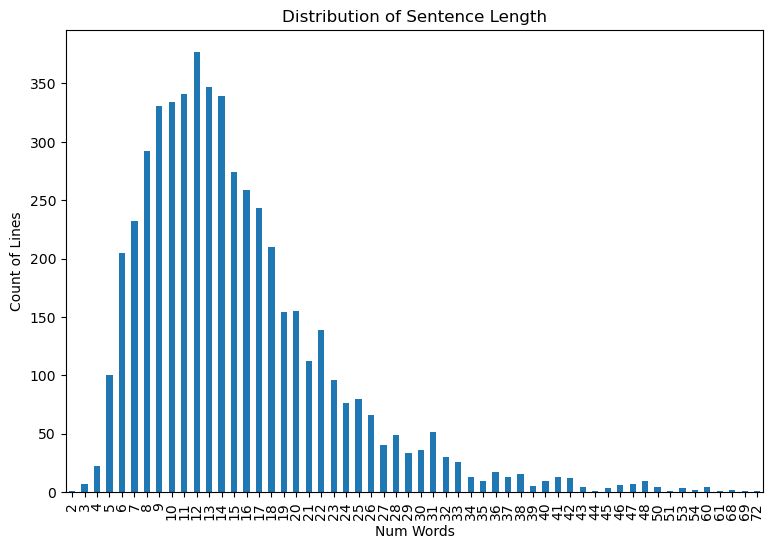

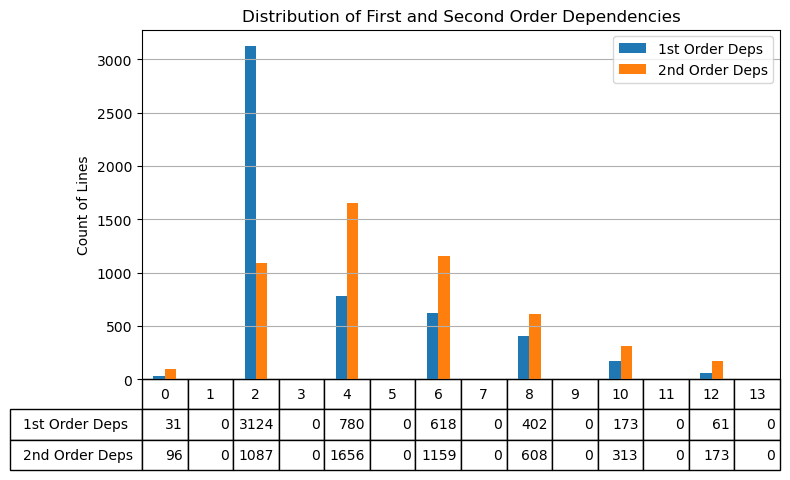

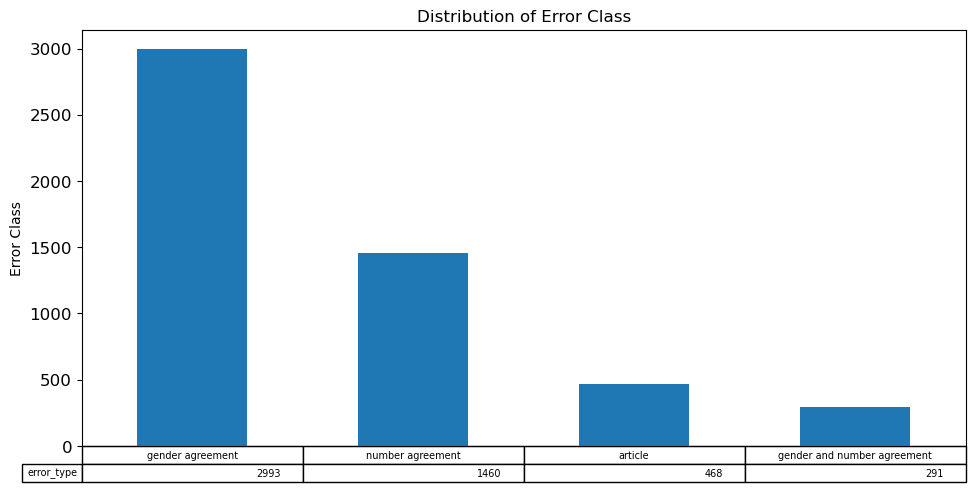

CPU times: user 3.27 s, sys: 1.1 s, total: 4.37 s
Wall time: 808 ms


In [74]:
%%time
# Plot the data
def build_df_dependencies(df):
    df_dependencies = pd.DataFrame({'Num Dependencies':list(range(0, 14))})
    df_dependencies['1st Order Deps'] = 0
    df_dependencies['2nd Order Deps'] = 0
    df_first_order =  df['First Order Dependencies'].value_counts().sort_index(axis=0)
    df_second_order =  df['Second Order Dependencies'].value_counts().sort_index(axis=0)
    for num_dependencies, count in df_first_order.items():
        df_dependencies.loc[df_dependencies['Num Dependencies'] == num_dependencies, '1st Order Deps'] = count
    for num_dependencies, count in df_second_order.items():
        df_dependencies.loc[df_dependencies['Num Dependencies'] == num_dependencies, '2nd Order Deps'] = count
    return df_dependencies

def build_dfs(df):
    df_plot = pd.DataFrame()
    df_plot['Sentence Len'] = df.apply(lambda row: len(row.target), axis=1)
    df_plot['Parsing Order Len'] = df.apply(lambda row: len(row.predicted_parsing_order) if row.predicted_parsing_order else 0, axis=1)
    df_plot['First Order Dependencies'] = df.apply(lambda row: count_by_order(row, 2), axis=1)
    df_plot['Second Order Dependencies'] = df.apply(lambda row: count_by_order(row, 3), axis=1)
    return df_plot, build_df_dependencies(df_plot)
    
def plots(df):
    df_plot, df_dependencies = build_dfs(df)
    
    df_plot['Sentence Len'].value_counts().sort_index(axis=0).plot(
        kind='bar',
        fontsize=10,
        figsize=(9, 6),
        xlabel="Num Words",
        ylabel="Count of Lines",
        xticks = None,
        title="Distribution of Sentence Length",
    )
    plt.savefig('training_report/sentence_len_distr.png', dpi=300, transparent=True)
    plt.show()

    plot_combo = df_dependencies.plot(
        kind='bar',
        x='Num Dependencies',
        fontsize=10,
        figsize=(8, 5),
        ylabel='Count of Lines',
        title='Distribution of First and Second Order Dependencies',
        grid=True,
        table=True
    )
    plot_combo.axes.get_xaxis().set_visible(False)
    # Getting the table created by pandas and matplotlib
    table = plot_combo.tables[0]
    # Setting the font size
    table.set_fontsize(10)
    # Rescaling the rows to be more readable
    table.scale(1,2)
    plt.tight_layout()
    plt.show()
    
    df_class_dist = df_errors.error_type.value_counts()    
    plot_classes = df_class_dist.plot(
        kind='bar',
        fontsize=12,
        figsize=(10, 5),
        xlabel="Number of samples",
        ylabel="Error Class",
        title="Distribution of Error Class",
        table=True)
    plot_classes.axes.get_xaxis().set_visible(False)
    # Getting the table created by pandas and matplotlib
    table = plot_classes.tables[0]
    # Setting the font size
    table.set_fontsize(10)
    # Rescaling the rows to be more readable
    table.scale(1,1)
    plt.tight_layout()
    plt.show()

plots(df_errors)

In [37]:
# Explore the rows with empty parsing order
# TODO: explore why about 30 rows have empty parsing orders and 38 rows are missing first order dependencies.
print(f'{df_errors[(df_errors.predicted_parsing_order.isna())].shape}')
with pd.option_context('display.max_colwidth', None):
    display(df_errors[df_errors.predicted_parsing_order.isna()])

(31, 24)


,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,full_error_tag,error_tag,correction,...,new_error_type,final_evident_index,target_sentence,source_sentence,error_type,evidence_index,predicted_parsing_order,origin,orig_error_type,predicted_parsing_order_src
65,65,72,412,6004f54d6469a368868a7377b03f3e9eb8d7a780202ab1862ad151095ab6e16b,SPA 3,"Después Harry Potter, J. K. Rowling ha estado muy ocupado.","Después Harry Potter, J. K. Rowling ha estado muy [ocupado]{ocupada}<ga:fm:adj:an>.",[ocupado]{ocupada}<ga:fm:adj:an>,ga:fm:adj:an,ocupada,...,gender agreement,[],"Después Harry Potter, J. K. Rowling ha estado muy ocupada.","Después Harry Potter, J. K. Rowling ha estado muy ocupado.",gender agreement,[],None,A,gender agreement,None
68,68,111,436,340344b3cfed0317bbb5c95dafdae2033cf7c6732f5ea383f2e64ffe93297fd5,SPA 3,En Shawshank Redemption -- un libro de Steven King que hicieron en pelicula -- el es un prisonero serviendo tiempo y ayuda otro prisonero sobrevivir los malos que una persona sufre quando esta encarcelado.,En Shawshank Redemption -- un libro de Steven King que hicieron en pelicula -- el es un prisonero serviendo tiempo y ayuda otro prisonero sobrevivir los malos que una persona sufre quando esta [encarcelado]{encarcelada}<ga:fm:adj:an>.,[encarcelado]{encarcelada}<ga:fm:adj:an>,ga:fm:adj:an,encarcelada,...,gender agreement,[],En Shawshank Redemption- - un libro de Steven King que hicieron en pelicula- - el es un prisonero serviendo tiempo y ayuda otro prisonero sobrevivir los malos que una persona sufre quando esta encarcelada.,En Shawshank Redemption- - un libro de Steven King que hicieron en pelicula- - el es un prisonero serviendo tiempo y ayuda otro prisonero sobrevivir los malos que una persona sufre quando esta encarcelado.,gender agreement,[],None,A,gender agreement,None
421,421,211,775,0c66030cc2c5487d1736df818425e524874d29ada3c571b76adb1731e1015055,SPA 2,"No tiene ""oscars"" pero Leonardo Dicaprio solomente recibió un oscar el año pasado, así que....Pues, quiero ver una película con él este año y quiero conocer Walken también.","No tiene ""oscars"" pero Leonardo Dicaprio solomente recibió un oscar el año pasado, así que....Pues, quiero ver una película con él este año y quiero conocer []{a}<az:do:an> Walken también.",[]{a}<az:do:an>,az:do:an,a,...,article,"[31, 33, 34, 71, 73, 74]","No tiene ""oscars"" pero Leonardo Dicaprio solomente recibió un oscar el año pasado, así que. . . . Pues, quiero ver una película con él este año y quiero conocer a Walken también.","No tiene ""oscars"" pero Leonardo Dicaprio solomente recibió un oscar el año pasado, así que. . . . Pues, quiero ver una película con él este año y quiero conocer [NONE] Walken también.",article,"[31, 33, 34, 71, 73, 74]",None,A,article,None
624,624,440,29,daeec1fa32f04db8a029f6cfe42d541e117b4e7621f61ae9fddbc7b5016766fc,SPA 3,Bill and Ted es de los dos Bill and Ted y els van en diferentes tiempos como los 1800’s o más patras.También van en la futuro.,Bill and Ted es de los dos Bill and Ted y els van en diferentes tiempos como los 1800’s o más patras.También van en [la]{el}<ga:mf:det:inan> futuro.,[la]{el}<ga:mf:det:inan>,ga:mf:det:inan,el,...,gender agreement,"[31, 32, 63, 64]",Bill and Ted es de los dos Bill and Ted y els van en diferentes tiempos como los 1800 ’ s o más patras. También van en el futuro.,Bill and Ted es de los dos Bill and Ted y els van en diferentes tiempos como los 1800 ’ s o más patras. También van en la futuro.,gender agreement,"[31, 32, 63, 64]",None,A,gender agreement,None
658,658,475,61,77581a46b29c5a9e1e74abbffea7e7a3c03b59fc3457647f571a1ba1ddbacce3,SPA 3,"Todavía me gusta escuchar ""Destiny's Child"" y su música es estupendo.","Todavía me gusta escuchar ""Destiny's Child"" y su música es [estupendo]{estupenda}<ga:fm:adj:inan>.",[estupendo]{estupenda}<ga:fm:adj:inan>,ga:fm:adj:inan,estupenda,...,gender agreement,"[16, 33]","Todavía me gusta escuchar ""Destiny' s Child"" y su música es estupenda.

In [38]:
df_errors[df_errors.essay_new == 'Me gustan muchos tipos de musica (rap, r&b,pop) , y muchas artistas.']

,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,full_error_tag,error_tag,correction,...,new_error_type,final_evident_index,target_sentence,source_sentence,error_type,evidence_index,predicted_parsing_order,origin,orig_error_type,predicted_parsing_order_src
1104,1104,946,336,52d24c89b5a3209f034532a43e7693abc52d49d3f25a2a...,SPA 2,"Me gustan muchos tipos de musica (rap, r&b,pop...","Me gustan muchos tipos de musica (rap, r&b,pop...",[muchas]{muchos}<ga:mf:det:an>,ga:mf:det:an,muchos,...,gender agreement,"[22, 23, 43, 44]","Me gustan muchos tipos de musica( rap, r& b, p...","Me gustan muchos tipos de musica( rap, r& b, p...",gender agreement,"[22, 23, 43, 44]",None,A,gender agreement,None


In [39]:
dep_parsing_tree(NLP_ES, 'Puedes visitar a sus amigos.', df_errors.iloc[363].correction_index, verbosity=2)


# COWSL2H_parsing_order(NLP_ES, df_errors, 363)

id -> head: {0: 1, 1: 1, 2: 4, 3: 4, 4: 1}
head -> ids: {1: [0, 1, 4], 4: [2, 3]}


{'1': 3, '2': 3, '3': 1, '4': 2}

In [40]:
ids_to_check = [946, 4833]
# print(df_errors.iloc[id_to_check])
# print(type(df_errors.iloc[id_to_check].source))
# print(type(df_errors.iloc[id_to_check].source))
# print(type(df_errors.iloc[id_to_check].essay_new))
for idx in ids_to_check:
    COWSL2H_parsing_order(NLP_ES, df_errors, idx)
# parsing_order = dep_parsing_tree(NLP_ES, df_errors.iloc[id_to_check].essay_new, eval(df_errors.iloc[id_to_check].correction_index), verbosity=2)


id -> head: {0: 1, 1: 1, 2: 3, 3: 1, 4: 1, 5: 7, 6: 7, 7: 4}
head -> ids: {1: [0, 1, 3, 4], 3: [2], 7: [5, 6], 4: [7]}


-----------------------------------------------

Orig: Le dice su amigo luchar con otras hombres .
Corr: Le dice su amigo luchar con otras hombres.
row.source: ['Le', 'dice', 'su', 'amigo', 'luchar', 'con', 'otras', 'hombres', '.']
row.target: ['Le', 'dice', 'su', 'amigo', 'luchar', 'con', 'otros', 'hombres', '.']
Concatenated: ['Le', 'dice', 'su', 'amigo', 'luchar', 'con', 'otras', 'hombres', '.', 'SEP', 'Le', 'dice', 'su', 'amigo', 'luchar', 'con', 'otros', 'hombres', '.']

Correction index: [6, 16]

Corrected offset: 10

computed pred_parse_order: {'4': 3, '5': 3, '6': 1, '7': 2}
id -> head: {0: 2, 1: 2, 2: 7, 3: 5, 4: 5, 5: 7, 6: 7, 7: 7, 8: 7, 9: 10, 10: 8, 11: 12, 12: 8, 14: 8}
head -> ids: {2: [0, 1], 7: [2, 5, 6, 7, 8], 5: [3, 4], 10: [9], 8: [10, 12, 14], 12: [11]}


-----------------------------------------------

Orig: En el vacaciones mi favoritas cosas hacer es comer muchas comidas para differente ( places ) .
Corr: En el vacacion mi favorito cosas hacer es comer muchas comida para differente (places).
row.source: ['En', 'el', 'vacaciones', 'mi', 'favoritas', 'cosas', 'hacer', 'es', 'comer', 'muchas', 'comidas', 'para', 'differente', '(', 'places', ')', '.']
row.target: ['En', 'la', 'vacaciones', 'mi', 'favoritas', 'cosas', 'hacer', 'es', 'comer', 'muchas', 'comidas', 'para', 'differente', '(', 'places', ')', '.']
Concatenated: ['En', 'el', 'vacaciones', 'mi', 'favoritas', 'cosas', 'hacer', 'es', 'comer', 'muchas', 'comidas', 'para', 'differente', '(', 'places', ')', '.', 'SEP', 'En', 'la', 'vacaciones', 'mi', 'favoritas', 'cosas', 'hacer', 'es', 'comer', 'muchas', 'comidas', 'para', 'differente', '(', 'places', ')', '.']

Correction index: [1, 19]

Corrected offset: 18

computed pred_parse_order: {'0': 3, '1': 1, '2': 2, '7': 3}


In [41]:
df_errors.sample(20)[['paragraph_id', 'sentence_id', 'full_error_tag', 'error_type', 'target_sentence']]

,paragraph_id,sentence_id,full_error_tag,error_type,target_sentence
3587,394,fad9adecf29b415e78858b7357702fcf0559ce28449e57...,[triste]{tristes}<na:ps:adj:inan>,number agreement,La mayoría de las veces las letras son tristes...
2587,1446,35d463ad5f397f2dcda7f56f6d9af043aab74d5b54961e...,[divertida]{divertido}<ga:mf:adj:an>,gender agreement,Quiero viajer con mi amigo que sea divertido.
543,1346,3ea9bbf117ac043c10f1f799eb2b82995049e1c8035810...,[]{a}<az:do:an>,article,"También, cada noche iríamos a un club diferent..."
3421,292,8c6aecee654e455d182eca477c470c4a82e543896ecd46...,[persona]{personas}<na:ps:noun:an>,number agreement,Hay muchas personas famosa en el mundo y cada ...
4293,1081,4b9c8c086254d300366203704f8c7161382b203681e764...,[vacacion]{vacaciones}<in:s:gat:noun:inan>,number agreement,Es una vacaciones perfecta.
4647,1380,aca8763b560527f6ac1726cf393c2fa535f27d8a6a5c42...,[favorita]{favoritas}<na:ps:adj:inan>,number agreement,mis favoritas vacaciones es cuando yo vaya a I...
3021,1360,086b4910eb1cbf7b7bd1d6c21e1bf84a5163161420de6c...,[al]{a la}<ga:fm:det:inan>,gender agreement,Voy a estar con mi mejor amiga y por la tarde ...
3845,719,31d15d3db856eaf5489b381a604c91c384c1c066baee48...,[muchos]{muchas}<ga:fm:det:an>,gender agreement,Están muchas famosas personas en el globo y es...
4442,1190,9b0ff2471aa244948f722cb02e4bdbff8572f9f0d1b3f2...,[difícil]{difíciles}<na:ps:adj:inan>,number agreement,Estoy muy contenta terminar mis clases porque ...
3783,652,1d697e4dc2e39862e42cca95ae435e381dd35ac93d4aef...,[al]{a los}<na:ps:det:inan>,number agreement,llegó a los Estados Unidos cuatro anos pasado ...


# Create Training Datasets

## Export Full Dataset

In [44]:
df_errors.to_csv(args.PROCESSED_DATA_FOLDER + "/final_with_errors.csv", index=False)

In [75]:
# Create the JSON version
# Export after remove lines with empty predicted parsing order until the underlying data is fixed.
export_as_json(df_errors, args.full_dataset.GEC_TRAIN_CSV, args.full_dataset.GEC_TEST_CSV, args.full_dataset.GEC_DEV_CSV)

Selected 5181 non-null rows from 5212 rows. 31 rows dropped.


In [76]:
# Create the NER version
# Convert training dataset to NER
to_ner(args.full_dataset.GEC_TRAIN_CSV, args.full_dataset.GEC_TRAIN_NER)

# Convert test dataset to NER
to_ner(args.full_dataset.GEC_TEST_CSV, args.full_dataset.GEC_TEST_NER)

# Convert dev dataset to NER
to_ner(args.full_dataset.GEC_DEV_CSV, args.full_dataset.GEC_DEV_NER)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Create Small Handcrafted Dataset

In [ ]:
# Sample 100 rows with 5 to 15 words
def sampled(df, min_len, max_len, num_per_class):
    df_filtered = df[(df.target.map(len) > min_len) & (df.target.map(len) < max_len)]
    classes = df_filtered.error_type.unique()
    df_selected = pd.concat([df_filtered[df_filtered.error_type == cur].sample(num_per_class) for cur in classes])    
    return df_selected

def create_small_dataset(df):
    df_small = sampled(df_errors, 5, 10, 25)
    # df_small.evidence_index = df_small.apply(evidence_index_for, axis=1)
    df_smaller = df_small #.sample(1)
    # df_smaller.evidence_index = df_smaller.apply(evidence_index_for, axis=1)
    df_smaller.to_csv(f'{args.PROCESSED_DATA_FOLDER}/bert_small_evidence.csv', index=False)
    return df_smaller
    # return df_small.sample(2).apply(evidence_index_for, axis=1)
    # .to_csv(f'{args.PROCESSED_DATA_FOLDER}/bert_small_evidence.csv', index=False)
    
df_errors_smaller = create_small_dataset(df_errors)

# Manually add evidence words
# Convert to JSON
# Create train-dev-test split
# Create NER output

In [ ]:
# def evidence_index_for(row, force_overwrite):
#     print(f'-------------------{row.orig_index}-------------------')
#     if len(row.evidence_index) > 0 and not force_overwrite:
#         # Already processed
#         print(f'-------------------using existing-------------------')
#         return row.evidence_index
#     print(f'Error Type: {row.error_type}')
#     print(f'Correction: {row.correction_index}')
#     print(f'X: {row.source}')
#     print(f'Y: {row.target}')    
#     user_opt = None
#     msg = f'Enter evidence indices (csv with each value between {0} and {len(row.source) - 1} ) or -1 to quit'
#     quit = False
#     evidence_indices = []
#     try:
#         user_input = input(f'{msg}: ')
#         if user_input == '-1':
#             quit = True
#         evidence_indices = eval(user_input)
#         print(f'Evidence indices: {evidence_indices}')
#     except ValueError:
#         print(msg)
#         user_opt = None

#     print(f'------------------------------------------------------')
#     if quit:
#         return []
#     else:
#         return evidence_indices
    
# def update_evidence_index(df, force_overwrite=False, num_rows=10):
#     count = 0
#     for i, row in df.iterrows():
#         if count >= num_rows:
#             break
#         if len(row.evidence_index) == 0 or force_overwrite:
#             df.at[i,'evidence_index'] = evidence_index_for(row, force_overwrite)
#             count = count + 1
#         # else:
#         #     print(f'-------------------{row.orig_index}-------------------')
#         #     # Already processed
#         #     print(f'-------------------using existing-------------------')

In [ ]:
# Do this only if you want to do manual annotation of evidence index again
# update_evidence_index(df_errors_smaller, num_rows=10)

In [ ]:
df_errors_smaller[df_errors_smaller.evidence_index.map(len) > 0].shape

In [ ]:
# Do this only if you want to do manual annotation of evidence index again
# Commenting it out to avoid accidental overwriting of manually annotated data
# df_errors_smaller.to_csv(f'{args.PROCESSED_DATA_FOLDER}/bert_small.csv', index=False)

In [ ]:
# Reload the smaller dataset
def load_smaller():
    # Converters not working
    df = pd.read_csv(args.PROCESSED_DATA_FOLDER + "/bert_small_evidence.csv", index_col=None, header=0)
    # The source, target and correction_index cols are loaded as string version of lists. Convert them to actual lists.
    df.source = df.apply(lambda row: eval(row.source), axis=1)
    df.target = df.apply(lambda row: eval(row.target), axis=1)
    df.correction_index = df.apply(lambda row: eval(row.correction_index), axis=1)
    df.evidence_index = df.apply(lambda row: eval(row.evidence_index), axis=1)
    df.predicted_parsing_order = df.apply(lambda row: eval(row.predicted_parsing_order), axis=1)
    return df

df_errors_smaller = load_smaller()
df_errors_smaller

In [ ]:
export_as_json(df_errors_smaller, args.small_dataset.GEC_TRAIN_CSV, args.small_dataset.GEC_TEST_CSV, args.small_dataset.GEC_DEV_CSV)

In [ ]:
# Play with the teeny dataset to check logic
def logic_check(df, num_rows=10):
    df_teeny = df[0:num_rows]
    
    # export_as_json(df_teeny, args.tiny_dataset.GEC_TRAIN_CSV, args.tiny_dataset.GEC_TEST_CSV, args.tiny_dataset.GEC_DEV_CSV)
    # to_ner(args.tiny_dataset.GEC_TEST_CSV, args.small_dataset.GEC_TEST_NER)
    to_ner("expect_tiny.csv", "expect_tiny.pkl")

logic_check(df_errors_smaller)

In [ ]:
# Convert training dataset to NER
to_ner(args.small_dataset.GEC_TRAIN_CSV, args.small_dataset.GEC_TRAIN_NER)

# Convert test dataset to NER
to_ner(args.small_dataset.GEC_TEST_CSV, args.small_dataset.GEC_TEST_NER)

# Convert dev dataset to NER
to_ner(args.small_dataset.GEC_DEV_CSV, args.small_dataset.GEC_DEV_NER)

## Export With Two Classes (Gender and Number)

In [48]:
def export_with_classes(df, classes, verbosity=1):
    as_set = set(classes)
    df_filtered = df[(df.error_type.map(lambda v: v in classes))]
    
    if verbosity > 0:
        print(f'Selected {df_filtered.shape[0]} rows from {df.shape[0]}')
        print(f'Classes in filtered dataframe: {df_filtered.error_type.unique()}')
    # Export JSON version
    export_as_json(df_filtered, args.two_classed_dataset.GEC_TRAIN_CSV, args.two_classed_dataset.GEC_TEST_CSV, args.two_classed_dataset.GEC_DEV_CSV)

    # Convert training dataset to NER
    to_ner(args.two_classed_dataset.GEC_TRAIN_CSV, args.two_classed_dataset.GEC_TRAIN_NER)

    # Convert test dataset to NER
    to_ner(args.two_classed_dataset.GEC_TEST_CSV, args.two_classed_dataset.GEC_TEST_NER)

    # Convert dev dataset to NER
    to_ner(args.two_classed_dataset.GEC_DEV_CSV, args.two_classed_dataset.GEC_DEV_NER)
    

export_with_classes(df_errors, ['gender agreement', 'number agreement'])

Selected 4453 rows from 5212
Classes in filtered dataframe: ['gender agreement' 'number agreement']
Selected 4432 non-null rows from 4453 rows. 21 rows dropped.


## Export Two Classes (GA and NA) for Plain Model

In this section, we will prepare the data for two plain vanilla NER models:
* Token classification approach using a classification layer on top of one or more of the BERT variants
* Translation approach using mT5 model

In [134]:
def export_for_plain(df, verbosity=1):
    def process_row(i, row):
        final_data = []
        previous_class = 'O'
        first = True
        set_corrections = set(row.correction_index)
        for i, word in enumerate(row.source):
            if i in set_corrections:
                if previous_class == 'O':
                    cls = f'B-{args.CLASS_IDS[row.error_type]}'
                else:
                    cls = f'I-{args.CLASS_IDS[row.error_type]}'
            else:
                cls = 'O'
            previous_class = cls    
            if first:
                first = False
                final_data.append([f'Sentence: {row.orig_index}', word, '', cls])
            else:
                final_data.append([f'', word, '', cls])
        return final_data
                
    def write_out(df, pkl_filename, csv_filename):
        final_data = []
        for i, row in df.iterrows():
            final_data.extend(process_row(i, row))
        cols = ['Sentence #','Word','POS','Tag']
        with open(f'{args.PROCESSED_DATA_FOLDER}/{pkl_filename}', 'wb') as f:
            pickle.dump([cols, *final_data], f)
        df_ner = pd.DataFrame(final_data, columns=cols)
        df_ner.to_csv(f'{args.PROCESSED_DATA_FOLDER}/{csv_filename}', index=False)

    df_filtered = df[(df.error_type == 'gender agreement') | (df.error_type == 'number agreement')]
    df_dups = df_filtered[df_filtered[['orig_index']].duplicated()]
    if df_dups.shape[0] > 1:
        raise Exception("Rows with duplicated orig_index found. Aborting.")
    if verbosity > 0:
        print(f'Selected {df_filtered.shape[0]} rows from {df.shape[0]}')
        print(f'Classes in filtered dataframe: {df_filtered.error_type.unique()}')
        print(f'Number of rows with duplicate orig_index: {df_dups.shape[0]}')

    train_df, test_dev_df = train_test_split(df_filtered, test_size=0.2)
    test_df, dev_df = train_test_split(test_dev_df, test_size=0.5)

    file_names = args.two_classed_plain_dataset
    write_out(train_df, file_names.GEC_TRAIN_NER, file_names.GEC_TRAIN_CSV)
    write_out(test_df, file_names.GEC_TEST_NER, file_names.GEC_TEST_CSV)
    write_out(dev_df, file_names.GEC_DEV_NER, file_names.GEC_DEV_CSV)

export_for_plain(df_errors)

Selected 4453 rows from 5212
Classes in filtered dataframe: ['gender agreement' 'number agreement']
Number of rows with duplicate orig_index: 0


In [135]:
from transformers import BertTokenizer, TFBertModel, T5Tokenizer, TFT5ForConditionalGeneration, AutoTokenizer, TFMT5ForConditionalGeneration
import io

In [136]:
import seaborn as sns

def addWord(tokenizer, word, ner):
    """
    Convert a word into a word token and add supplied NER labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc.
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    return addDict

def analyze_generated(config, state):
    sentLengthList = state['sentLengthList']
    bertSentenceIDs = state['bertSentenceIDs']
    nerTokenList = state['nerTokenList']
    bertMasks = state['bertMasks']
    sentLengthList = state['sentLengthList']
    max_length = state['max_length']
    sentenceLengths= [l for l in sentLengthList]

    # let us check what was generated
    print(f'sentenceTokenList({len(state["sentenceTokenList"][2])}): {state["sentenceTokenList"][2]}')
    print()
    print(f'nerTokenList({len(state["nerTokenList"][2])}): {state["nerTokenList"][2]}')
    print()
    print(f'bertMasks({len(state["bertMasks"][2])}): {state["bertMasks"][2]}')

    plt.hist(np.array(sentenceLengths), bins=(max_length-2))
    plt.title(f'{config["name"]} - Sentence Lengths')

    plt.show()
    
    numSentences = len(bertSentenceIDs)
    state['numSentences'] = numSentences
    nerClasses = pd.DataFrame(np.array(nerTokenList).reshape(-1))
    nerClasses.columns = ['tag']
    
    nerClasses.tag = pd.Categorical(nerClasses.tag)
    nerClasses['cat'] = nerClasses.tag.cat.codes
    nerClasses['sym'] = nerClasses.tag.cat.codes
    nerLabels = np.array(nerClasses.cat).reshape(numSentences, -1) 
    
    state['NUM_ORIG_CLASSES'] = 3
    state['NUM_NER_CLASSES'] = 4
    state['NUM_TOTAL_CLASSES'] = state['NUM_ORIG_CLASSES'] + state['NUM_NER_CLASSES'] 
    state['nerClassesTag'] = pd.Categorical(nerClasses.tag)
    state['nerLabels'] = nerLabels
    
    nerClasses[['cat']].hist(bins=state['NUM_TOTAL_CLASSES'])
    plt.title(f'{config["name"]} - Class Distribution')
    plt.show()
    
    nerDistribution = (nerClasses.groupby(['tag', 'cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))

    print(nerDistribution.to_markdown())
    
    O_occurences = int(nerDistribution.loc[nerDistribution.tag == 'O','occurences']\
                                    .reset_index().drop(['index'], axis=1).loc[2])   # Some gymnasics to get the count..
    ga_occurences = nerDistribution[nerDistribution.cat == 0]['occurences'].sum()
    na_occurences = nerDistribution[nerDistribution.cat == 1]['occurences'].sum()
    All_occurences = nerDistribution[nerDistribution.cat < 3]['occurences'].sum()
    
    fig1, ax1 = plt.subplots()

    pie_sizes = [ga_occurences, na_occurences, O_occurences]
    pie_labels = ['Gender', 'Number', 'No Error']
    legend_labels = ['{} ({:.0f})'.format(l, s) for l, s in zip(pie_labels, pie_sizes)]

    ax1.pie(
        np.array([ga_occurences, na_occurences, O_occurences]),
        # labels = ['Gender', 'Number', 'No Error'],
        # autopct=lambda p: '{:.2f}% \n({:.0f})'.format(p, p * All_occurences / 100),
        autopct=lambda p: '{:.2f}%'.format(p),
        explode=[0, 0.12, 0.12],
        colors=sns.color_palette('Set2')
    )
    ax1.axis('equal')
    # plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=legend_labels)
    plt.legend(labels=legend_labels)
    plt.tight_layout()
    plt.savefig('training_report/class_imbalance.png', dpi=300, transparent=True)
    plt.title('Class Imbalance')
    plt.show() 

    print()
    print(f'\'O\' class percentage: {O_occurences}/{All_occurences} = {round((O_occurences * 100)/All_occurences, 2)}%')
    print(f'\'B-ga\' class percentage: {ga_occurences}/{All_occurences} = {round((ga_occurences * 100)/All_occurences, 2)}%')
    print(f'\'B-na\' class percentage: {na_occurences}/{All_occurences} = {round((na_occurences * 100)/All_occurences, 2)}%')
    
    return state
    
def split_and_export(state, filename, seed=42):
    trainSentence_ids = []
    trainMasks = []
    trainSequence_ids = []

    testSentence_ids = []
    testMasks = []
    testSequence_ids = []

    nerLabels_train =[]
    nerLabels_test = []

    bertSentenceIDs = state['bertSentenceIDs']
    bertSequenceIDs = state['bertSequenceIDs']
    bertMasks = state['bertMasks']
    nerLabels = state['nerLabels']
    numSentences = state['numSentences']
    
    bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])
    numSentences = len(bert_inputs[0])
    state['numSentences'] = numSentences
    np.random.seed(seed)
    training_examples = np.random.binomial(1, 0.7, numSentences)
    
    for example in range(numSentences):
        if training_examples[example] == 1:
            trainSentence_ids.append(bert_inputs[0][example])
            trainMasks.append(bert_inputs[1][example])
            trainSequence_ids.append(bert_inputs[2][example])
            nerLabels_train.append(nerLabels[example])
        else:
            testSentence_ids.append(bert_inputs[0][example])
            testMasks.append(bert_inputs[1][example])
            testSequence_ids.append(bert_inputs[2][example])
            nerLabels_test.append(nerLabels[example])

    X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
    X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

    nerLabels_train = np.array(nerLabels_train)
    nerLabels_test = np.array(nerLabels_test)   
    
    print(f'X_train[0,0]: {X_train[0,0]}')
    print(f'nerLabels_train[0]:{nerLabels_train[0]}')
    print(f'sentenceTokenList[0]: {state["sentenceTokenList"][0]}')
    print(f'training_examples[:10]: {training_examples[:10]}')

    k_start = 0

    k_end_train = X_train[0].shape[0]
    k_end_test = X_test[0].shape[0]

    bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                           X_train[2][k_start:k_end_train]]
    bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                          X_test[2][k_start:k_end_test]]


    labels_train_k = nerLabels_train[k_start:k_end_train]
    labels_test_k = nerLabels_test[k_start:k_end_test]
    
    train_all = [bert_inputs_train_k, labels_train_k]
    test_all = [bert_inputs_test_k, labels_test_k]
    
    training_data = {
        'nerClassesTag': state['nerClassesTag'],
        'bertModelName':state['model_name'],
        'numSentences': state['numSentences'],
        'NUM_ORIG_CLASSES': state['NUM_ORIG_CLASSES'],
        'NUM_NER_CLASSES': state['NUM_NER_CLASSES'],
        'NUM_TOTAL_CLASSES': state['NUM_TOTAL_CLASSES'],
        'train_all': train_all,
        'test_all': test_all
    }
    
    with open(f'{args.PROCESSED_DATA_FOLDER}/{filename}', "wb") as output_file:
        pickle.dump(training_data, output_file)

def prep_for(config):
    config_name = config['name']
    model_name = config['model_name']
    dev_filename = config['dev_intermediate_file']
    train_filename = config['train_intermediate_file']
    test_filename = config['test_intermediate_file']
    max_length = config['max_length']
    
    text = []
    with io.open(f'{args.PROCESSED_DATA_FOLDER}/{train_filename}', 'r', encoding='utf-8', errors='ignore') as train:
        text = train.readlines()[1:-1] # Read ignoring the header line

    with io.open(f'{args.PROCESSED_DATA_FOLDER}/{dev_filename}', 'r', encoding='utf-8', errors='ignore') as eval:
        text.extend(eval.readlines()[1: -1]) # Read ignoring the header line

    with io.open(f'{args.PROCESSED_DATA_FOLDER}/{test_filename}', 'r', encoding='utf-8', errors='ignore') as test:
        text.extend(test.readlines()[1: -1]) # Read ignoring the header line

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # lists for sentences, tokens, labels, etc.  
    sentenceList = []
    sentenceTokenList = []
    nerTokenList = []
    sentLengthList = []

    # lists for BERT input
    bertSentenceIDs = []
    bertMasks = []
    bertSequenceIDs = []

    sentence = ''

    # always start with [CLS] tokens
    sentenceTokens = ['[CLS]']
    nerTokens = ['[nerCLS]']
    
    for line in text:
        line = line.replace('\n', '')
        cleanLine = re.sub(r'(?!(([^"]*"){2})*[^"]*$),', '', line)  # deal with '"10,000"' and convert them to '10000' 
        sent, word, pos, ner = cleanLine.split(',')

        # if new sentence starts
        if (sent[:8] == 'Sentence'):            
            sentenceLength = min(max_length -1, len(sentenceTokens))
            sentLengthList.append(sentenceLength)

            # Create space for at least a final '[SEP]' token
            if sentenceLength >= max_length - 1: 
                sentenceTokens = sentenceTokens[:max_length - 2]
                nerTokens = nerTokens[:max_length - 2]

            # add a ['SEP'] token and padding
            sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
            nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )
            sentenceList.append(sentence)
            sentenceTokenList.append(sentenceTokens)

            bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
            bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
            bertSequenceIDs.append([0] * (max_length))

            nerTokenList.append(nerTokens)
            sentence = ''
            sentenceTokens = ['[CLS]']
            posTokens = ['[posCLS]']
            nerTokens = ['[nerCLS]']

            sentence += ' ' + word

        addDict = addWord(tokenizer, word, ner)
        sentenceTokens += addDict['wordToken']
        nerTokens += addDict['nerToken']
        
    # The first list element need to be removed as it does not a sentence.
    sentLengthList = sentLengthList[1:]
    sentenceTokenList = sentenceTokenList[1:]
    bertSentenceIDs = bertSentenceIDs[1:]
    bertMasks = bertMasks[1:]
    bertSequenceIDs = bertSequenceIDs[1:]
    nerTokenList = nerTokenList[1:]

    state = {
        'model_name': model_name,
        'sentLengthList': sentLengthList,
        'sentenceTokenList': sentenceTokenList,
        'bertSentenceIDs': bertSentenceIDs,
        'bertMasks': bertMasks,
        'bertSequenceIDs': bertSequenceIDs,
        'nerTokenList': nerTokenList,
        'max_length': max_length
    }
    
    state = analyze_generated(config, state)
    split_and_export(state, config['train_data_file'])

sentenceTokenList(40): ['[CLS]', 'también', '"', '"', 'me', 'gustaría', 'viajar', 'los', 'ciudades', 'menos', 'porque', 'tienen', 'mucha', 'historia', 'sobre', 'los', 'indig', '##enas', 'de', 'tai', '##w', '##an', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

nerTokenList(40): ['[nerCLS]', 'O', 'O', 'nerX', 'O', 'O', 'O', 'B-ga', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'O', 'O', 'nerX', 'nerX', 'O', '[nerSEP]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]']

bertMasks(40): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


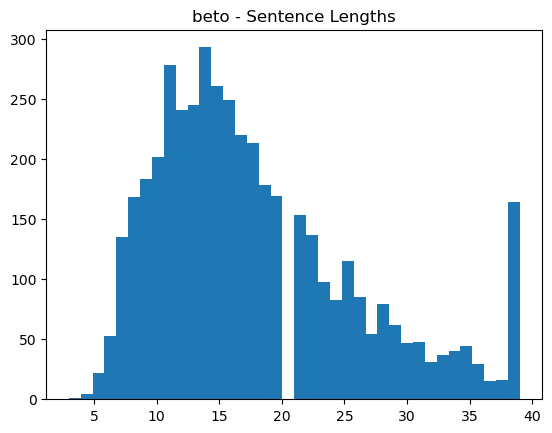

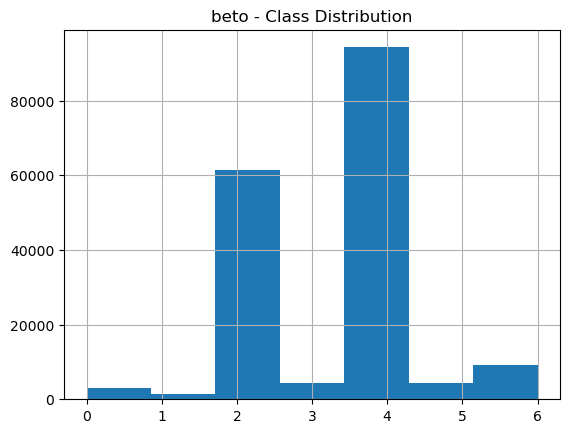

|    | tag      |   cat |   occurences |
|---:|:---------|------:|-------------:|
|  0 | B-ga     |     0 |         2965 |
|  1 | B-ga     |     1 |            0 |
|  2 | B-ga     |     2 |            0 |
|  3 | B-ga     |     3 |            0 |
|  4 | B-ga     |     4 |            0 |
|  5 | B-ga     |     5 |            0 |
|  6 | B-ga     |     6 |            0 |
|  7 | B-na     |     0 |            0 |
|  8 | B-na     |     1 |         1448 |
|  9 | B-na     |     2 |            0 |
| 10 | B-na     |     3 |            0 |
| 11 | B-na     |     4 |            0 |
| 12 | B-na     |     5 |            0 |
| 13 | B-na     |     6 |            0 |
| 14 | O        |     0 |            0 |
| 15 | O        |     1 |            0 |
| 16 | O        |     2 |        61279 |
| 17 | O        |     3 |            0 |
| 18 | O        |     4 |            0 |
| 19 | O        |     5 |            0 |
| 20 | O        |     6 |            0 |
| 21 | [nerCLS] |     0 |            0 |
| 22 | [nerCLS] 

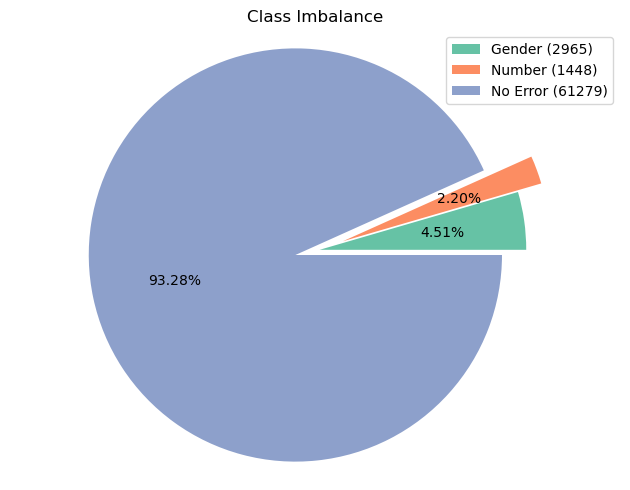


'O' class percentage: 61279/65692 = 93.28%
'B-ga' class percentage: 2965/65692 = 4.51%
'B-na' class percentage: 1448/65692 = 2.2%
X_train[0,0]: [   4 1512 2331 1491 5561 1105 1076 1067 3067 1040 1085 4258 1008    5
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1]
nerLabels_train[0]:[3 2 2 0 2 6 2 2 2 2 2 2 2 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4]
sentenceTokenList[0]: ['[CLS]', 'ella', 'gusta', 'bueno', 'educa', '##cion', 'por', 'los', 'chicos', 'y', 'las', 'chicas', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
training_examples[:10]: [1 0 0 1 1 1 1 0 1 0]
sentenceTokenList(30): ['[CLS]', 'También', '"', '"', 'me', 'gu', '##star', '##ía', 'viajar', 'los', 'ciudades', 'menos', 'porque', 

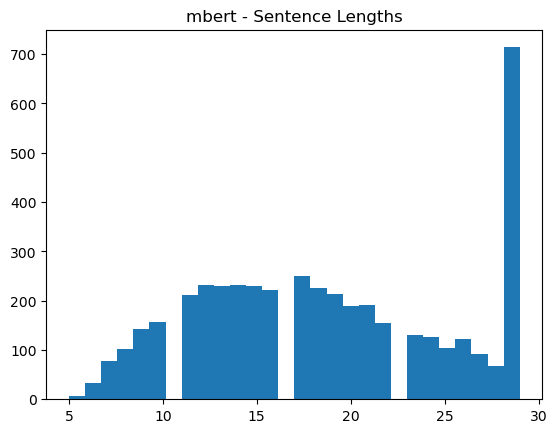

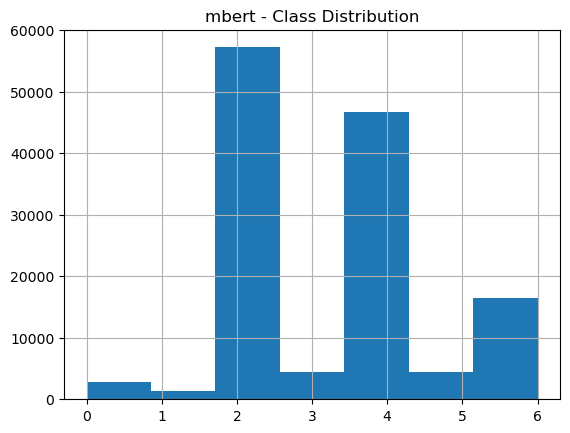

|    | tag      |   cat |   occurences |
|---:|:---------|------:|-------------:|
|  0 | B-ga     |     0 |         2884 |
|  1 | B-ga     |     1 |            0 |
|  2 | B-ga     |     2 |            0 |
|  3 | B-ga     |     3 |            0 |
|  4 | B-ga     |     4 |            0 |
|  5 | B-ga     |     5 |            0 |
|  6 | B-ga     |     6 |            0 |
|  7 | B-na     |     0 |            0 |
|  8 | B-na     |     1 |         1399 |
|  9 | B-na     |     2 |            0 |
| 10 | B-na     |     3 |            0 |
| 11 | B-na     |     4 |            0 |
| 12 | B-na     |     5 |            0 |
| 13 | B-na     |     6 |            0 |
| 14 | O        |     0 |            0 |
| 15 | O        |     1 |            0 |
| 16 | O        |     2 |        57221 |
| 17 | O        |     3 |            0 |
| 18 | O        |     4 |            0 |
| 19 | O        |     5 |            0 |
| 20 | O        |     6 |            0 |
| 21 | [nerCLS] |     0 |            0 |
| 22 | [nerCLS] 

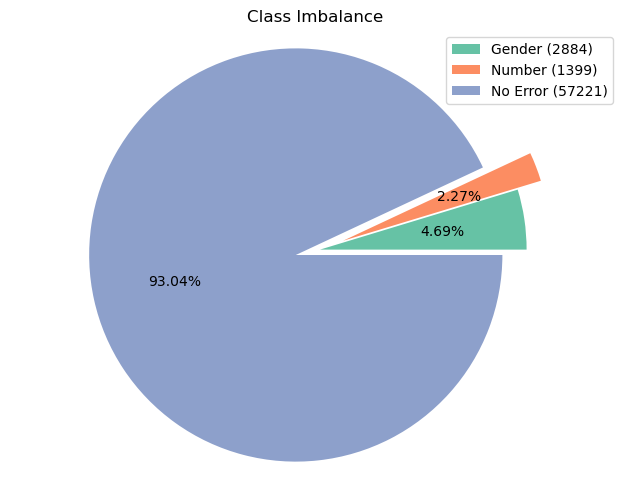


'O' class percentage: 57221/61504 = 93.04%
'B-ga' class percentage: 2884/61504 = 4.69%
'B-na' class percentage: 1399/61504 = 2.27%
X_train[0,0]: [  101 26450 75980 10972 49341 10133 23037 10425 15204 10183 10182 14325
 15023   193 10285 96813 10107   119   102     0     0     0     0     0
     0     0     0     0     0     0]
nerLabels_train[0]:[3 2 2 6 0 6 2 6 6 2 2 2 6 2 2 2 6 2 5 4 4 4 4 4 4 4 4 4 4 4]
sentenceTokenList[0]: ['[CLS]', 'Ella', 'gu', '##sta', 'buen', '##o', 'edu', '##ca', '##cion', 'por', 'los', 'chi', '##cos', 'y', 'las', 'chica', '##s', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
training_examples[:10]: [1 0 0 1 1 1 1 0 1 0]


In [137]:
for config in args.bert_plain_models:
    prep_for(config)

In [225]:
# # let us check what was generated
# print(f'sentenceTokenList({len(state["sentenceTokenList"][2])}): {state["sentenceTokenList"][2]}')
# print()
# print(f'nerTokenList({len(state["nerTokenList"][2])}): {state["nerTokenList"][2]}')
# print()
# print(f'bertMasks({len(state["bertMasks"][2])}): {state["bertMasks"][2]}')

In [226]:
# state = analyze_generated(result)

## Export GA and NA for Plain Model in WNUT17 Format

In [28]:
# Export data as
# {'id': '0',
# 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0],
# 'tokens': ['@paulwalk', 'It', "'s", 'the', 'view', 'from', 'where', 'I', "'m", 'living', 'for', 'two', 'weeks', '.', 'Empire', 'State', 'Building', '=', 'ESB', '.', 'Pretty', 'bad', 'storm', 'here', 'last', 'evening', '.']
#}

def export_wnut17(df, args, include_ew=False, verbosity=0):
    def b_or_i(previous, class_id):
        if previous == 'O' or previous == 'B-ew':
            return f'B-{class_id}'
        else:
            return f'I-{class_id}'
        
    def process_row(i, row):
        final_data = []
        previous_class = 'O'
        first = True
        set_corrections = set(row.correction_index)
        set_evidences = set(row.evidence_index)
        classes = []
        for i, word in enumerate(row.source):
            if i in set_corrections:
                cls = b_or_i(previous_class, args.CLASS_IDS[row.error_type])
            else:
                if include_ew and i in set_evidences:
                    cls = 'B-ew'
                else:
                    cls = 'O'
            previous_class = cls 
            cls_id = args.label2id[cls]
            classes.append(cls_id)
                           
        return [row.orig_index, classes, row.source]

    def write_out(df, csv_filename):
        final_data = []
        for i, row in df.iterrows():
            final_data.append(process_row(i, row))
        print(final_data[0:2])
        cols = ['id', 'ner_tags', 'tokens']
        df_ner = pd.DataFrame(final_data, columns=cols)
        df_ner.to_csv(f'{args.PROCESSED_DATA_FOLDER}/{csv_filename}', index=False)

    df_filtered = df[(df.error_type == 'gender agreement') | (df.error_type == 'number agreement')]
    # Create a separate test dataset for final evaluation.

    df_train, df_test = train_test_split(df_filtered, test_size=0.05)
    write_out(df_train, 'two_class_wnut17_train.csv')
    write_out(df_test, 'two_class_wnut17_val.csv')

In [29]:
export_wnut17(df_errors, args, verbosity=1, include_ew=True)

[[2603, [3, 3, 2, 1, 3, 3, 3, 3], ['Adamás', ',', 'mi', 'vacación', 'perfecta', 'es', 'barata', '.']], [92, [3, 3, 3, 3, 3, 1, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], ['Primero', 'yo', 'necesito', 'enterarse', 'cuando', 'mi', 'hermanos', ',', 'mi', 'mejor', 'amiga', 'y', 'yo', 'no', 'tenemos', 'escuela', 'y', 'mi', 'mama', ',', 'mi', 'abuela', 'y', 'mi', 'tío', 'no', 'trabajan', '.']]]
[[3646, [3, 3, 3, 3, 0, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], ['Recomiendo', 'que', 'tú', 'veas', 'todos', 'las', 'películas', 'de', 'Streep', 'pero', 'especialmente', '"', 'The', 'Devil', 'Wears', 'Prada', '.', '"']], [2179, [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3], ['Me', 'encantana', 'mucho', 'snowboarding', 'y', 'quiero', 'snowboard', 'en', 'mismo', 'lugar', 'que', 'mi', 'athletas', 'favoritos', '.']]]


In [30]:
df_errors.sample(2)

,orig_index,Unnamed: 0,paragraph_id,sentence_id,course,essay_new,annotated_sentence,full_error_tag,error_tag,correction,...,correction_index,new_error_type,final_evident_index,target_sentence,source_sentence,error_type,evidence_index,predicted_parsing_order,origin,orig_error_type
4655,4655,510,1380,791a859bc7060fe66769b076efa6947278910742bb0c02...,SPA 3,"Mi próxima vacaciones estaban Santiago España,...",[Mi]{mis}<na:ps:det:inan> [próxima]{próximas}<...,[próxima]{próximas}<na:ps:det:inan>,na:ps:det:inan,próximas,...,"[1, 16]",number agreement,"[2, 17]",mis próximas vacaciones estaban Santiago Españ...,mis próxima vacaciones estaban Santiago España...,number agreement,"[2, 17]",,A,number agreement
810,810,635,183,df0603a45d02e8b3e6839b02a2807b9f3c080f6d0c3adc...,SPA 3,Oprah tiene muchas programas de televisión.,Oprah tiene [muchas]{muchos}<ga:mf:noun:aty:in...,[muchas]{muchos}<ga:mf:noun:aty:inan>,ga:mf:noun:aty:inan,muchos,...,"[2, 10]",gender agreement,"[1, 3, 9, 11]",Oprah tiene muchos programas de televisión.,Oprah tiene muchas programas de televisión.,gender agreement,"[1, 3, 9, 11]",,A,gender agreement
